### **Import Libraries and Read Data**

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns

In [151]:
train = pd.read_excel("trainDATA.xlsx", index_col = None)
test = pd.read_excel("testDATA.xlsx", index_col = None)

In [152]:
X = train.iloc[:,:-1].to_numpy()
Y = train.iloc[:,-1:].to_numpy()

test_X = test.iloc[:,:].to_numpy()
test_Y = []

### **Define Model**

In [153]:
feature_names = train.columns
max_depth = 10

In [154]:
class Node:
  def __init__(self, left=None, right=None, feature=None, value=None, leaf=False):
    self.left = left
    self.right = right
    self.feature = feature
    self.value = value
    self.leaf = leaf

  def is_leaf(self):
    return self.leaf

  def print(self, depth = 0, is_left = True):
    if self.leaf:
      print((" "*depth*4) + ("yes: " if is_left==True else "no: ") + str(self.value))

    else:
      if depth == 0:
        print(str(feature_names[self.feature]) + " <= " + str(self.value) + "?")

      else:
        print((" "*depth*4) + ("yes: " if is_left==True else "no: ") 
              + str(feature_names[self.feature]) + " <= " + str(self.value) + "?")
              
      self.left.print(depth+1)
      self.right.print(depth+1, is_left=False)


In [155]:
def calculate_entropy(Y):
  n_samples = len(Y)
  _, counts = np.unique(Y, return_counts=True)

  entropy = 0
  for count in counts:
    p = count / n_samples
    entropy += -p * np.log2(p)

  return entropy

def calculate_gain(Y, Y_left, Y_right):
  p = len(Y)
  p_left = len(Y_left)
  p_right = len(Y_right)

  parent_entropy = calculate_entropy(Y)
  left_entropy = calculate_entropy(Y_left)
  right_entropy = calculate_entropy(Y_right)

  gain = parent_entropy - (p_left / p) * left_entropy - (p_right / p) * right_entropy
  return gain

def split_data(X, Y, feature, value, left=True):
  if left:
    mask = X[:, feature] <= value
    return X[mask], Y[mask]
  else:
    mask = X[:, feature] > value
    return X[mask], Y[mask]

def calculate_tree(X, Y, depth):
  _, n_features = X.shape
  
  if depth >= max_depth:
    unique_values, counts = np.unique(Y, return_counts=True)
    leaf_value =  unique_values[np.argmax(counts)]
    return Node(leaf=True, value=leaf_value)

  best_gain = 0
  best_feature = 0
  best_value = 0

  for feature in range(n_features):
    for value in X[:, feature]:
      X_left, Y_left = split_data(X, Y, feature, value)
      X_right, Y_right = split_data(X, Y, feature, value, left=False)

      gain = calculate_gain(Y, Y_left, Y_right)
      
      if gain > best_gain:
        best_gain = gain
        best_feature = feature
        best_value = value

  X_left, Y_left = split_data(X, Y, best_feature, best_value)
  X_right, Y_right = split_data(X, Y, best_feature, best_value, left=False)
  
  if Y_left.shape[0] == 0 or Y_right.shape[0] == 0:
    return Node(leaf=True, value=Y[0][0])

  left_tree = calculate_tree(X_left, Y_left, depth + 1)
  right_tree = calculate_tree(X_right, Y_right, depth + 1)
  node = Node(left=left_tree, right=right_tree, feature=best_feature, value=best_value)
  return node

tree = calculate_tree(X, Y, depth=0)

In [156]:
def predict_recursive(node, x):
  if node.is_leaf():
    return node.value
  
  feature = node.feature
  value = node.value
  if x[feature] <= value:
    return predict_recursive(node.left, x)
  else:
    return predict_recursive(node.right, x)
    
def predict(X):
  y_pred = []
  for x in X:
    y_pred.append(predict_recursive(tree, x))
  return np.array(y_pred)

### **Predict Data**

In [157]:
predicted_Y = predict(X)
test_Y = predict(test_X)

### **Figure Tree**

In [158]:
tree.print()

Persons <= 2?
    yes: 1
    no: Safety <= 1?
        yes: 1
        no: Price <= 2?
            yes: MaintPrice <= 3?
                yes: Lug_size <= 1?
                    yes: Safety <= 2?
                        yes: 1
                        no: NoofDoors <= 2?
                            yes: Persons <= 4?
                                yes: MaintPrice <= 1?
                                    yes: Price <= 1?
                                        yes: 1
                                        no: 2
                                    no: 2
                                no: 1
                            no: MaintPrice <= 1?
                                yes: Price <= 1?
                                    yes: 1
                                    no: 2
                                no: 2
                    no: MaintPrice <= 1?
                        yes: Price <= 1?
                            yes: 1
                            no: NoofDoors <= 3?
                   

### **Calculate Confusing Matrix**

In [159]:
true_positive = np.sum(np.logical_and(predicted_Y == 2, Y.flatten() == 2))
true_negative = np.sum(np.logical_and(predicted_Y == 1, Y.flatten() == 1))
false_positive = np.sum(np.logical_and(predicted_Y == 2, Y.flatten() == 1))
false_negative = np.sum(np.logical_and(predicted_Y == 1, Y.flatten() == 2))
 
print ('True Negative: %i, False Negative: %i \nFalse Positive: %i, True Positive: %i' 
        % (true_negative,false_negative,false_positive,true_positive))

True Negative: 992, False Negative: 2 
False Positive: 2, True Positive: 304


<AxesSubplot: >

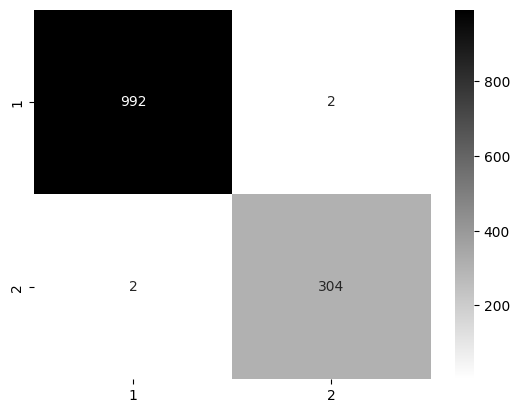

In [160]:
confusing_matrix = [[true_negative,false_negative],
                    [false_positive,true_positive]]
                    
sns.heatmap(confusing_matrix, annot=True, fmt='g', cmap='binary', xticklabels=[1,2], yticklabels=[1,2])

### **Calculate Metrics**

In [161]:
accuarcy_score = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) 
print("Accuarcy Score:", accuarcy_score)

Accuarcy Score: 0.9969230769230769


In [162]:
precision_score = true_positive / (true_positive + false_positive) 
print("Precision Score:", precision_score)

Precision Score: 0.9934640522875817


In [163]:
recall_score = true_positive / (true_positive + false_negative) 
print("Recall Score:", recall_score)

Recall Score: 0.9934640522875817


In [164]:
f1_score = (2 * precision_score * recall_score) / (precision_score + recall_score) 
print("F1 Score:", f1_score)

F1 Score: 0.9934640522875817


### **Test**